In this problem we will train a neural network from scratch using numpy. In practice, you will never need to do this (you'd just use TensorFlow or PyTorch). But hopefully this will give us a sense of what's happening under the hood. 

For training/testing, we will use the standard MNIST benchmark consisting of images of handwritten images. 



In the second demo, we worked with autodiff. Autodiff enables us to implicitly store how to calculate the gradient when we call backward. We implemented some basic operations (addition, multiplication, power, and ReLU). In this homework problem, you will implement backprop for more complicated operations directly. Instead of using autodiff, you will manually compute the gradient of the loss function for each parameter.

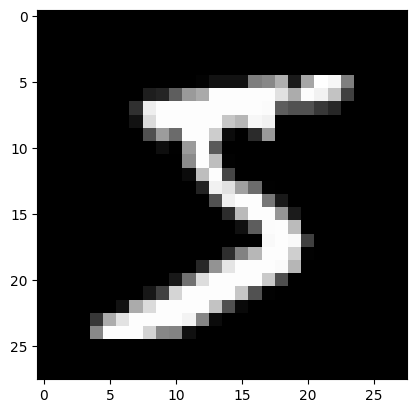

In [43]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

plt.imshow(x_train[0],cmap='gray');

Loading MNIST is the only place where we will use TensorFlow; the rest of the code will be pure numpy.

Let us now set up a few helper functions. We will use sigmoid activations for neurons, the softmax activation for the last layer, and the cross entropy loss.

In [44]:
import numpy as np

def sigmoid(x):
  # Numerically stable sigmoid function based on
  # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
  
  x = np.clip(x, -500, 500) # We get an overflow warning without this
  
  return np.where(
    x >= 0,
    1 / (1 + np.exp(-x)),
    np.exp(x) / (1 + np.exp(x))
  )

def dsigmoid(x): # Derivative of sigmoid
  return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
  # Numerically stable softmax based on (same source as sigmoid)
  # http://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
  b = x.max()
  y = np.exp(x - b)
  return y / y.sum()

def cross_entropy_loss(y, yHat):
  return -np.sum(y * np.log(yHat))

def integer_to_one_hot(x, max):
  # x: integer to convert to one hot encoding
  # max: the size of the one hot encoded array
  result = np.zeros(10)
  result[x] = 1
  return result

OK, we are now ready to build and train our model. The input is an image of size 28x28, and the output is one of 10 classes. So, first: 

Q1. Initialize a 2-hidden layer neural network with 32 neurons in each hidden layer, i.e., your layer sizes should be: 

784 -> 32 -> 32 -> 10

If the layer is $n_{in} \times n_{out}$ your layer weights should be initialized by sampling from a normal distribution with mean zero and variance 1/$\max(n_{in},n_{out})$.

### Weight and Bias Initialization

- The bias term for each layer is initialized to zero.
- The weights for each layer are initialized by sampling from a normal distribution with mean zero and variance that depends on the size of the layer. We can use various strategies to define the standard deviation of the normal distribution. A common one is to use 1/$\sqrt max(n_{in},n_{out})$, where $n_{in}$ and $n_{out}$ are the number of input and output units for the layer. Although, there are a few others that can also be used and may affect model performance. 1/$\max{n_{in},n_{out}}$ had lower performance in my experiments.


In [49]:
# # Initialize weights of each layer with a normal distribution of mean 0 and
# # standard deviation 1/sqrt(n), where n is the number of inputs.
# # This means the weighted input will be a random variable itself with mean
# # 0 and standard deviation close to 1 (if biases are initialized as 0, standard
# # deviation will be exactly 1)

from numpy.random import default_rng

rng = default_rng(80085)


import numpy as np

def standard_deviation(n_in, n_out, method='xavier'):
    if method == 'sqrtmax':
        return 1 / np.sqrt(max(n_in, n_out))
    if method == 'max':
        return 1 / max(n_in, n_out)
    if method == 'xavier':
        return 1 / np.sqrt(n_in)
    if method == 'he':
        return 2 / np.sqrt(n_in)
    if method == 'he2':
        return 2 / np.sqrt(n_in + n_out)
    raise ValueError('Invalid method')

# Network architecture: 784 -> 32 -> 32 -> 10
input_size = 28 * 28  # 784
hidden_size = 32
output_size = 10

weights = []
biases = []

# Layer 1: Input (784) -> Hidden1 (32)
n_in, n_out = input_size, hidden_size
std = standard_deviation(n_in, n_out, 'sqrtmax')
weights.append(np.random.randn(n_out, n_in) * std)  # shape: (32,784)
biases.append(np.zeros(n_out))

# Layer 2: Hidden1 (32) -> Hidden2 (32)
n_in, n_out = hidden_size, hidden_size
std = standard_deviation(n_in, n_out, 'sqrtmax')
weights.append(np.random.randn(n_out, n_in) * std)  # shape: (32,32)
biases.append(np.zeros(n_out))

# Layer 3: Hidden2 (32) -> Output (10)
n_in, n_out = hidden_size, output_size
std = standard_deviation(n_in, n_out, 'sqrtmax')
weights.append(np.random.randn(n_out, n_in) * std)  # shape: (10,32)
biases.append(np.zeros(n_out))


Next, we will set up the forward pass. We will implement this by looping over the layers and successively computing the activations of each layer. 

Q2. Implement the forward pass for a single sample, and for the entire dataset.


Right now, your network weights should be random, so doing a forward pass with the data should not give you any meaningful information. Therefore, in the last line, when you calculate test accuracy, it should be somewhere around 1/10 (i.e., a random guess).

### Forward Pass 

In this step, we will implement the forward pass of the neural network for a single sample and for the entire dataset. 

The forward pass for the single step is given by the following equations:

\begin{align}
z_1 &= xW_1 + b_1 \\
a_1 &= \sigma(z_1) \\
z_2 &= a_1W_2 + b_2 \\
a_2 &= \sigma(z_2) \\
z_3 &= a_2W_3 + b_3 \\
a_3 &= \text{softmax}(z_3)
\end{align}

where $x$ is the input, $W_i$ and $b_i$ are the weights and biases for the $i$-th layer, $\sigma$ is the sigmoid activation function, and $\text{softmax}$ is the softmax activation function.

The softmax function simply applies the exponential function to each element of the input vector and then normalizes the output vector to have a sum of 1

This step simply calculates the inference of the neural network on the test and training data based on the weights and biases that we have initialized.

In [50]:
def feed_forward_sample(sample, y):
    """
    Forward pass for a single sample.
    Inputs:
      sample: a 2D numpy array (28x28) for the MNIST digit.
      y: integer label (0-9).
    Returns:
      loss: cross entropy loss for this sample.
      one_hot_guess: one-hot encoded prediction (vector of length 10).
    """
    # Flatten the sample into a vector of size 784
    x = sample.flatten()  # shape (784,)
    
    # Layer 1: hidden layer
    z1 = np.dot(weights[0], x) + biases[0]      # shape (128,)
    a1 = sigmoid(z1)                            # shape (128,)
    
    # Layer 2: output layer
    z2 = np.dot(weights[1], a1) + biases[1]       # shape (10,)
    a2 = sigmoid(z2)                            # shape (10,)

     # Layer 3 forward
    z3 = np.dot(weights[2], a2) + biases[2]
    a3 = softmax(z3)
    
    # Compute loss using cross-entropy; convert y to one-hot
    y_one_hot = integer_to_one_hot(y, output_size)
    loss = cross_entropy_loss(y_one_hot, a3)
    
    # Get prediction as one-hot vector
    pred_label = np.argmax(a3)
    one_hot_guess = np.zeros(output_size)
    one_hot_guess[pred_label] = 1
    
    return loss, one_hot_guess


def feed_forward_dataset(x, y):
  losses = np.empty(x.shape[0])
  one_hot_guesses = np.empty((x.shape[0], output_size))

  for i in range(x.shape[0]):
          loss, one_hot_guess = feed_forward_sample(x[i], y[i])
          losses[i] = loss
          one_hot_guesses[i] = one_hot_guess
  
  y_one_hot = np.zeros((y.size, 10))
  y_one_hot[np.arange(y.size), y] = 1

  correct_guesses = np.sum(y_one_hot * one_hot_guesses)
  correct_guess_percent = format((correct_guesses / y.shape[0]) * 100, ".2f")  

  print("\nAverage loss:", np.round(np.average(losses), decimals=2))
  print("Accuracy (# of correct guesses):", correct_guesses, "/", y.shape[0], "(", correct_guess_percent, "%)")

def feed_forward_training_data():
  print("Feeding forward all training data...")
  feed_forward_dataset(x_train, y_train)
  print("")

def feed_forward_test_data():
  print("Feeding forward all test data...")
  feed_forward_dataset(x_test, y_test)
  print("")

feed_forward_test_data()

Feeding forward all test data...

Average loss: 2.43
Accuracy (# of correct guesses): 989.0 / 10000 ( 9.89 %)



OK, now we will implement the backward pass using backpropagation. We will keep it simple and just do training sample-by-sample (no minibatching, no randomness).

Q3: Compute the gradient of all the weights and biases by backpropagating derivatives all the way from the output to the first layer. 





### Model Training: Forward and Backward Pass

- The forward pass computes the predicted output for a given input.
-- The forward pass implemented here is the same as the one we implemented in the previous step
- The backward pass computes the gradient of the loss with respect to the weights and biases.
-- The backward pass is implemented here by computing the gradients of the loss with respect to the weights and biases of each layer. The gradients are computed by backpropagating the derivatives from the output layer to  the input layer. The gradients are then used to update the weights and biases of the network using the gradient descent algorithm. The equations for the gradients are derived using the chain rule. The equation is as follows:

$$\frac{\partial L}{\partial W} = \frac{\partial L}{\partial a} \frac{\partial a}{\partial z} \frac{\partial z}{\partial W}$$

In [51]:
def train_one_sample(sample, y, learning_rate=0.003):
    x = sample.flatten()  # shape: (784,)
    
    # Forward pass
    z1 = np.dot(weights[0], x) + biases[0]  # (32,)
    a1 = sigmoid(z1)
    
    z2 = np.dot(weights[1], a1) + biases[1]   # (32,)
    a2 = sigmoid(z2)
    
    z3 = np.dot(weights[2], a2) + biases[2]   # (10,)
    a3 = softmax(z3)
    
    y_one_hot = integer_to_one_hot(y, output_size)
    loss = cross_entropy_loss(y_one_hot, a3)
    
    # Backward pass:
    # Output layer: derivative of softmax-crossentropy
    delta3 = a3 - y_one_hot                  # (10,)
    dW3 = np.outer(delta3, a2)               # (10,32)
    db3 = delta3
    
    # Backpropagate to second hidden layer:
    delta2 = np.dot(weights[2].T, delta3) * dsigmoid(z2)  # (32,)
    dW2 = np.outer(delta2, a1)                            # (32,32)
    db2 = delta2
    
    # Backpropagate to first hidden layer:
    delta1 = np.dot(weights[1].T, delta2) * dsigmoid(z1)  # (32,)
    dW1 = np.outer(delta1, x)                             # (32,784)
    db1 = delta1
    
    # Update weights and biases
    weights[2] -= learning_rate * dW3
    biases[2] -= learning_rate * db3
    weights[1] -= learning_rate * dW2
    biases[1] -= learning_rate * db2
    weights[0] -= learning_rate * dW1
    biases[0] -= learning_rate * db1
    
    return loss

Finally, train for 3 epochs by looping over the entire training dataset 3 times.

Q4. Train your model for 3 epochs.

### Model Training: Looping Over the Dataset

The model is trained by looping over the entire training dataset for a fixed number of epochs. The forward and backward passes are computed for each sample in the dataset. The gradients are then used to update the weights and biases of the network using the gradient descent algorithm. The loss is computed for each sample and the average loss is computed for the entire dataset. 

In [52]:

def train_one_epoch(learning_rate=0.003):
    print("Training for one epoch over the training dataset...")
    total_loss = 0.0
    num_samples = x_train.shape[0]
    
    # Loop through every sample in the training set
    for i in range(num_samples):
        loss = train_one_sample(x_train[i], y_train[i], learning_rate)
        total_loss += loss
        if (i+1) % 10000 == 0:
            print(f"Processed {i+1}/{num_samples} samples")
    
    avg_loss = total_loss / num_samples
    print("Finished training epoch. Average Loss:", np.round(avg_loss, decimals=4), "\n")

feed_forward_test_data()

def test_and_train():
  train_one_epoch()
  feed_forward_test_data()

for i in range(3): 
  test_and_train()

Feeding forward all test data...

Average loss: 2.43
Accuracy (# of correct guesses): 989.0 / 10000 ( 9.89 %)

Training for one epoch over the training dataset...
Processed 10000/60000 samples
Processed 20000/60000 samples
Processed 30000/60000 samples
Processed 40000/60000 samples
Processed 50000/60000 samples
Processed 60000/60000 samples
Finished training epoch. Average Loss: 1.2322 

Feeding forward all test data...

Average loss: 1.05
Accuracy (# of correct guesses): 6302.0 / 10000 ( 63.02 %)

Training for one epoch over the training dataset...
Processed 10000/60000 samples
Processed 20000/60000 samples
Processed 30000/60000 samples
Processed 40000/60000 samples
Processed 50000/60000 samples
Processed 60000/60000 samples
Finished training epoch. Average Loss: 0.9951 

Feeding forward all test data...

Average loss: 0.96
Accuracy (# of correct guesses): 6773.0 / 10000 ( 67.73 %)

Training for one epoch over the training dataset...
Processed 10000/60000 samples
Processed 20000/60000


That's it! 

Your code is probably very time- and memory-inefficient; that's ok. There is a ton of optimization under the hood in professional deep learning frameworks which we won't get into.

If everything is working well, you should be able to raise the accuracy from ~10% to ~70% accuracy after 3 epochs.